# AI Final Project (Data Notebook)

Yutai Li, Coco Yu\
Data source: https://www.kaggle.com/datasets/debanga/facial-expression-recognition-challenge
`
This project is aimed at classifying images into seven categories: anger, disgust, fear, happiness, sadness, surprise and neutral. The original data contain 35,887 instances including three columns: emotions (target), pixels (feature) and usage. The usage column is useless for our purpose (we plan to use sklearn package to split training and testing sets) and was therefore dropped. 3,369 duplicate values were found and taken out of the dataset. Number of instances for each target category can be found in the following codes. As there are some error images (e.g., image removed), we did some exploratory in the data and set a threshold of 230 for average pixels to remove these error images. For the purpose of our project, we only need gray scale images. As the original dataset is already on gray scale, we thereby did not manipulate the pixels.
`

## Data Cleaning

In [4]:
import math
import numpy as np
from numpy import random
import pandas as pd
import seaborn as sns
from matplotlib import pyplot

In [5]:
# Access data from my GCS bucket
from google.colab import auth
auth.authenticate_user()

# Dataset Location:
# https://console.cloud.google.com/storage/browser/fm_grayscale

In [6]:
!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2537  100  2537    0     0  63425      0 --:--:-- --:--:-- --:--:-- 63425
OK
76 packages can be upgraded. Run 'apt list --upgradable' to see them.
gcsfuse is already the newest version (0.41.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 76 not upgraded.


In [7]:
!mkdir colab_direcoty
!gcsfuse --implicit-dirs fm_grayscale colab_direcoty

mkdir: cannot create directory ‘colab_direcoty’: File exists
2022/05/31 16:31:22.562560 Start gcsfuse/0.41.2 (Go version go1.17.6) for app "" using mount point: /content/colab_direcoty
2022/05/31 16:31:22.574957 Opening GCS connection...
2022/05/31 16:31:22.889198 Mounting file system "fm_grayscale"...
2022/05/31 16:31:22.890472 File system has been successfully mounted.


In [8]:
!ls colab_direcoty

color.json  icml_face_data.csv	test.csv


In [9]:
face_df = pd.read_csv('colab_direcoty/icml_face_data.csv')
face_df.columns = ["emotion", "usage", "pixels"]
face_df.head()

,emotion,usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


### locate and drop duplicates

In [10]:
duplicates = face_df[face_df.duplicated(subset = 'pixels', keep=False)]
duplicates

,emotion,usage,pixels
30,3,Training,234 233 228 231 234 233 236 230 236 196 112 85...
38,0,Training,255 82 0 3 0 0 0 0 0 0 3 0 16 17 3 60 29 0 1 2...
50,2,Training,99 95 101 114 124 129 128 127 128 124 123 125 ...
62,3,Training,210 161 140 166 159 98 96 141 157 137 110 107 ...
69,5,Training,43 43 43 40 45 63 93 140 144 153 159 167 168 1...
...,...,...,...
35826,2,PrivateTest,200 201 199 197 198 199 199 198 197 196 194 19...
35833,5,PrivateTest,254 254 254 254 254 253 252 254 113 36 62 69 6...
35874,5,PrivateTest,43 43 51 73 94 97 102 95 99 107 126 144 154 17...
35875,5,PrivateTest,248 251 239 144 102 95 82 77 91 138 153 145 14...


In [11]:
duplicates[duplicates['pixels'] == duplicates.iloc[0,2]]

,emotion,usage,pixels
30,3,Training,234 233 228 231 234 233 236 230 236 196 112 85...
19215,3,Training,234 233 228 231 234 233 236 230 236 196 112 85...


In [12]:
len(duplicates)

3369

In [13]:
face_df = face_df.drop_duplicates(subset="pixels", keep='first')

In [14]:
face_df

,emotion,usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
...,...,...,...
35881,0,PrivateTest,181 177 176 156 178 144 136 132 122 107 131 16...
35882,6,PrivateTest,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...
35883,3,PrivateTest,178 174 172 173 181 188 191 194 196 199 200 20...
35884,0,PrivateTest,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...


In [15]:
# face_df.iloc[:,1].value_counts()

### Investigate the emotions column and transform to text

In [16]:
face_df['emotion'].value_counts()

3    8796
6    6052
4    5922
2    4820
0    4727
5    3257
1     460
Name: emotion, dtype: int64

**Discovery: There are significantly less disgust emotions in the dataset.**

In [17]:
# take out the usage column
# face_df = face_df[['emotion', 'pixels']]
# face_df.head()

In [18]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [19]:
def transform_emotion(emotion):
    return emotion_label_to_text[emotion]

face_df["emotion_label"] = face_df["emotion"].apply(transform_emotion)
face_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,emotion,usage,pixels,emotion_label
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,anger
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...,anger
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...,fear
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,sadness
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,neutral
...,...,...,...,...
35881,0,PrivateTest,181 177 176 156 178 144 136 132 122 107 131 16...,anger
35882,6,PrivateTest,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,neutral
35883,3,PrivateTest,178 174 172 173 181 188 191 194 196 199 200 20...,happiness
35884,0,PrivateTest,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,anger


In [20]:
face_df['emotion_label'].value_counts()

happiness    8796
neutral      6052
sadness      5922
fear         4820
anger        4727
surprise     3257
disgust       460
Name: emotion_label, dtype: int64

### Plot pictures and eliminate error images

172


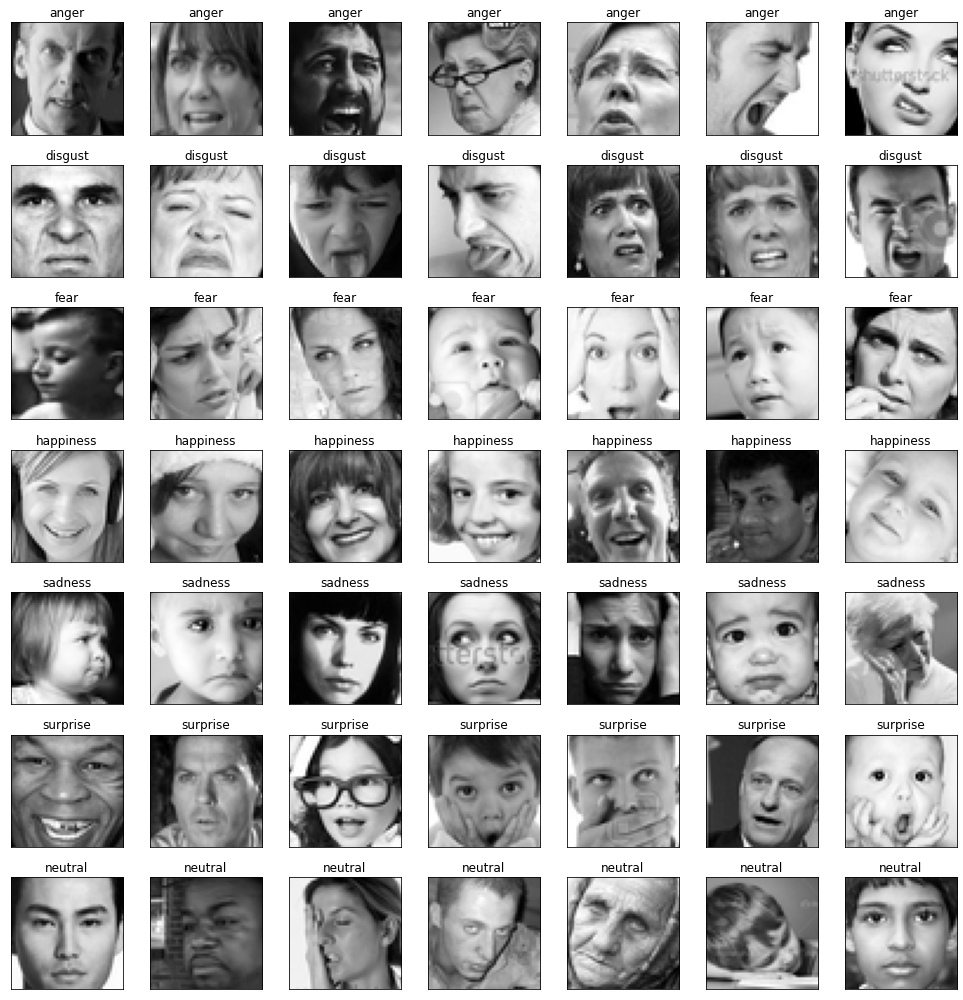

In [21]:
fig = pyplot.figure(1, (14, 14))

random.seed(0)
n = random.randint(0, high=460)
# n = 194
k = 0
print(n)

for label in sorted(face_df.emotion.unique()):
    for j in range(7):
        px = face_df[face_df.emotion==label].pixels.iloc[n]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        n += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        pyplot.tight_layout()

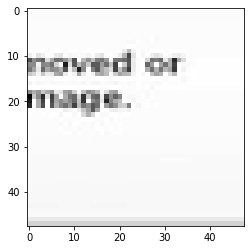

In [22]:
# error images
error_img = face_df[face_df.emotion==5].pixels.iloc[229]
error_img = np.array(error_img.split(' ')).reshape(48, 48).astype('float32')
ax = pyplot.subplot()
ax.imshow(error_img, cmap='gray')

In [23]:
error_img

array([[252., 252., 252., ..., 252., 252., 252.],
       [252., 252., 252., ..., 252., 252., 252.],
       [252., 252., 252., ..., 252., 252., 252.],
       ...,
       [251., 251., 251., ..., 251., 251., 251.],
       [241., 241., 241., ..., 241., 241., 241.],
       [225., 225., 225., ..., 225., 225., 225.]], dtype=float32)

In [24]:
np.average(error_img)

245.42578

In [25]:
random_pic = face_df['pixels'][0]
random_pic = np.array(random_pic.split(' ')).reshape(48, 48).astype('float32')
np.average(random_pic)

117.59288

In [26]:
def find_average(pixels):
    return np.average(pixels)

def transform_pixel(pixels):
    return np.array(pixels.split(" ")).reshape(48, 48).astype("float32")

face_df["pixels"] = face_df["pixels"].apply(transform_pixel)
face_df["mean"] = face_df["pixels"].apply(find_average)

face_df

,emotion,usage,pixels,emotion_label,mean
0,0,Training,"[[70.0, 80.0, 82.0, 72.0, 58.0, 58.0, 60.0, 63...",anger,117.592880
1,0,Training,"[[151.0, 150.0, 147.0, 155.0, 148.0, 133.0, 11...",anger,126.971352
2,2,Training,"[[231.0, 212.0, 156.0, 164.0, 174.0, 138.0, 16...",fear,160.814240
3,4,Training,"[[24.0, 32.0, 36.0, 30.0, 32.0, 23.0, 19.0, 20...",sadness,130.503479
4,6,Training,"[[4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",neutral,97.900177
...,...,...,...,...,...
35881,0,PrivateTest,"[[181.0, 177.0, 176.0, 156.0, 178.0, 144.0, 13...",anger,164.295135
35882,6,PrivateTest,"[[50.0, 36.0, 17.0, 22.0, 23.0, 29.0, 33.0, 39...",neutral,63.258682
35883,3,PrivateTest,"[[178.0, 174.0, 172.0, 173.0, 181.0, 188.0, 19...",happiness,171.759979
35884,0,PrivateTest,"[[17.0, 17.0, 16.0, 23.0, 28.0, 22.0, 19.0, 17...",anger,161.609802


In [27]:
## set threshold to 230
error_set = face_df[face_df['mean'] >= 230]
error_set.reset_index(drop=True, inplace = True)
error_set

,emotion,usage,pixels,emotion_label,mean
0,5,Training,"[[252.0, 252.0, 252.0, 252.0, 252.0, 252.0, 25...",surprise,245.425781
1,5,Training,"[[254.0, 254.0, 254.0, 254.0, 254.0, 254.0, 25...",surprise,248.087234
2,5,Training,"[[253.0, 253.0, 253.0, 253.0, 253.0, 253.0, 25...",surprise,242.844620
3,2,Training,"[[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 25...",fear,242.663635
4,3,Training,"[[255.0, 254.0, 254.0, 254.0, 253.0, 254.0, 25...",happiness,244.990891
5,2,Training,"[[252.0, 252.0, 252.0, 252.0, 252.0, 252.0, 25...",fear,235.333328
6,0,Training,"[[254.0, 254.0, 254.0, 254.0, 254.0, 254.0, 25...",anger,244.865021
7,5,Training,"[[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 25...",surprise,238.618484
8,3,Training,"[[254.0, 254.0, 254.0, 254.0, 254.0, 254.0, 25...",happiness,243.335938
9,3,Training,"[[254.0, 254.0, 254.0, 254.0, 254.0, 254.0, 25...",happiness,241.969177


In [28]:
error_set.iloc[1, 2]

array([[254., 254., 254., ..., 254., 254., 254.],
       [254., 254., 254., ..., 254., 254., 254.],
       [254., 254., 254., ..., 254., 254., 254.],
       ...,
       [254., 254., 254., ..., 254., 254., 254.],
       [254., 254., 254., ..., 254., 254., 254.],
       [254., 254., 254., ..., 254., 254., 254.]], dtype=float32)

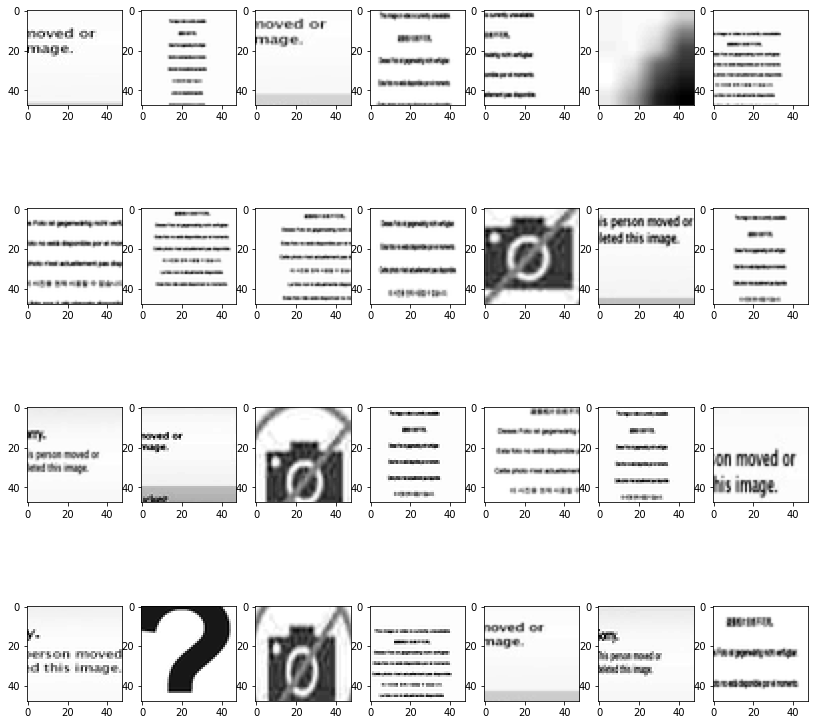

In [29]:
fig = pyplot.figure(1, (14, 14))
k = 1
for i in range(len(error_set)): 
    ax = pyplot.subplot(4,7,k)
    ax.imshow(error_set.iloc[i,2], cmap='gray')
    k += 1

In [30]:
## set threshold to 220
error_set220 = face_df[(face_df['mean'] >= 220) & (face_df['mean'] < 230)]
error_set220.reset_index(drop=True, inplace = True)
error_set220

,emotion,usage,pixels,emotion_label,mean
0,5,Training,"[[255.0, 249.0, 246.0, 247.0, 248.0, 249.0, 24...",surprise,221.253906
1,0,Training,"[[245.0, 221.0, 251.0, 254.0, 253.0, 255.0, 18...",anger,223.685760
2,3,Training,"[[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 25...",happiness,220.050354
3,2,Training,"[[206.0, 203.0, 203.0, 206.0, 236.0, 255.0, 25...",fear,226.347656
4,5,Training,"[[255.0, 255.0, 255.0, 252.0, 255.0, 183.0, 15...",surprise,223.851135
5,3,Training,"[[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 25...",happiness,224.223953
6,5,Training,"[[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 25...",surprise,222.271698
7,4,Training,"[[255.0, 255.0, 255.0, 255.0, 255.0, 255.0, 25...",sadness,224.969620
8,5,Training,"[[254.0, 254.0, 254.0, 254.0, 254.0, 254.0, 25...",surprise,228.647568
9,5,Training,"[[254.0, 254.0, 254.0, 254.0, 254.0, 254.0, 25...",surprise,229.396698


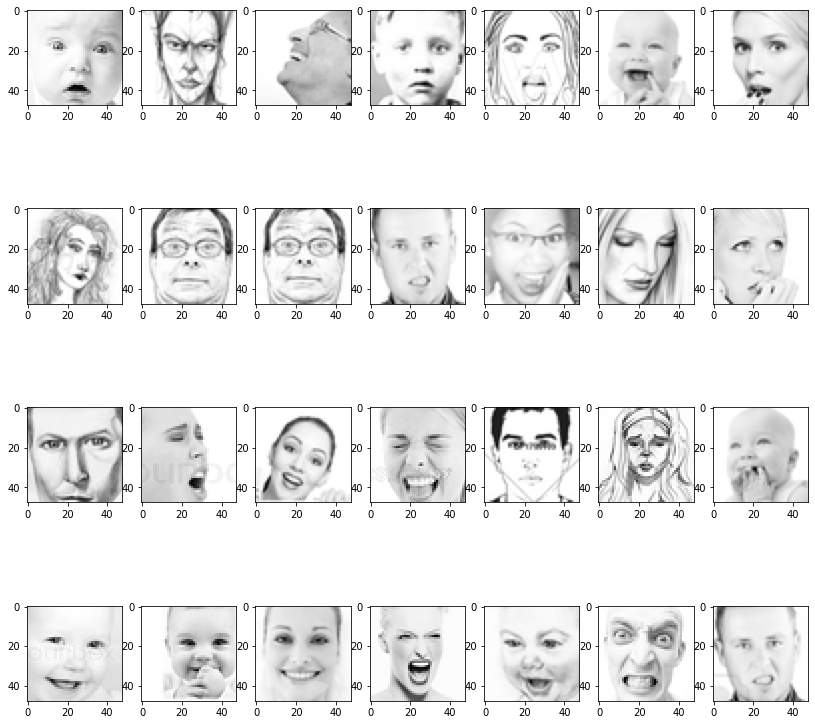

In [31]:
fig = pyplot.figure(1, (14, 14))
k = 1
for i in range(len(error_set220)): 
    ax = pyplot.subplot(4,7,k)
    ax.imshow(error_set220.iloc[i,2], cmap='gray')
    k += 1

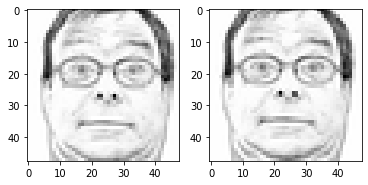

In [32]:
for i in range(2): 
    ax = pyplot.subplot(1,2,i+1)
    ax.imshow(error_set220.iloc[8+i,2], cmap='gray')

In [33]:
np.array_equal(error_set220.iloc[8,2], error_set220.iloc[9,2])

False

In [34]:
valid_face_df = face_df[face_df['mean'] <= 230]
valid_face_df.reset_index(drop=True, inplace = True)
valid_face_df

,emotion,usage,pixels,emotion_label,mean
0,0,Training,"[[70.0, 80.0, 82.0, 72.0, 58.0, 58.0, 60.0, 63...",anger,117.592880
1,0,Training,"[[151.0, 150.0, 147.0, 155.0, 148.0, 133.0, 11...",anger,126.971352
2,2,Training,"[[231.0, 212.0, 156.0, 164.0, 174.0, 138.0, 16...",fear,160.814240
3,4,Training,"[[24.0, 32.0, 36.0, 30.0, 32.0, 23.0, 19.0, 20...",sadness,130.503479
4,6,Training,"[[4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",neutral,97.900177
...,...,...,...,...,...
34001,0,PrivateTest,"[[181.0, 177.0, 176.0, 156.0, 178.0, 144.0, 13...",anger,164.295135
34002,6,PrivateTest,"[[50.0, 36.0, 17.0, 22.0, 23.0, 29.0, 33.0, 39...",neutral,63.258682
34003,3,PrivateTest,"[[178.0, 174.0, 172.0, 173.0, 181.0, 188.0, 19...",happiness,171.759979
34004,0,PrivateTest,"[[17.0, 17.0, 16.0, 23.0, 28.0, 22.0, 19.0, 17...",anger,161.609802


In [35]:
valid_face_df['pixels'].dtypes

dtype('O')

## Convolutional Neural Network (Run on Google Colab with GPU)

### Model Training

In [36]:
! pip install tensorflow
! pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [37]:
# import scikitplot
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.optimizers import Adam
from keras.utils import np_utils

In [38]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
emotion_encoder = le.fit_transform(valid_face_df["emotion_label"])

valid_face_df["emotion_encoder"] = emotion_encoder
valid_face_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,emotion,usage,pixels,emotion_label,mean,emotion_encoder
0,0,Training,"[[70.0, 80.0, 82.0, 72.0, 58.0, 58.0, 60.0, 63...",anger,117.592880,0
1,0,Training,"[[151.0, 150.0, 147.0, 155.0, 148.0, 133.0, 11...",anger,126.971352,0
2,2,Training,"[[231.0, 212.0, 156.0, 164.0, 174.0, 138.0, 16...",fear,160.814240,2
3,4,Training,"[[24.0, 32.0, 36.0, 30.0, 32.0, 23.0, 19.0, 20...",sadness,130.503479,5
4,6,Training,"[[4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",neutral,97.900177,4
...,...,...,...,...,...,...
34001,0,PrivateTest,"[[181.0, 177.0, 176.0, 156.0, 178.0, 144.0, 13...",anger,164.295135,0
34002,6,PrivateTest,"[[50.0, 36.0, 17.0, 22.0, 23.0, 29.0, 33.0, 39...",neutral,63.258682,4
34003,3,PrivateTest,"[[178.0, 174.0, 172.0, 173.0, 181.0, 188.0, 19...",happiness,171.759979,3
34004,0,PrivateTest,"[[17.0, 17.0, 16.0, 23.0, 28.0, 22.0, 19.0, 17...",anger,161.609802,0


In [39]:
def find_X_y(df):
    image_array = np.array(df['pixels'].values.tolist()).reshape(len(df), 48, 48, 1)
    image_array = np.stack(image_array, axis=0)

    return image_array, df["emotion_encoder"]

X_train, y_train = find_X_y(valid_face_df.loc[valid_face_df['usage'].isin(["Training"])])
X_test, y_test= find_X_y(valid_face_df.loc[valid_face_df['usage'].isin(["PublicTest", "PrivateTest"])])

In [40]:
# image_array = np.array(valid_face_df['pixels'].values.tolist()).reshape(len(valid_face_df), 48, 48, 1)
# image_array = np.stack(image_array, axis=0)

In [41]:
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# image_labels = le.fit_transform(valid_face_df["emotion_label"])
# image_labels = np_utils.to_categorical(image_labels)

In [42]:
# image_labels = le.inverse_transform(image_labels)
# image_labels

In [43]:
# image_labels[0:5]

In [44]:
# le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
# print(le_name_mapping)

In [45]:
# X_train, X_valid, y_train, y_valid = train_test_split(image_array, image_labels,
#                                                     shuffle=True, stratify=image_labels,
#                                                     test_size=0.3, random_state=42)
# X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

In [46]:
image_width = X_train.shape[1]
image_height = X_train.shape[2]
image_depth = X_train.shape[3]
num_classes = 7

In [47]:
# Normalization
X_train = X_train / 255.
X_test = X_test/ 255.

In [48]:
cnn_model= Sequential([
    Conv2D(filters=36, kernel_size=7, activation='relu', input_shape=(image_width, image_height, image_depth)),
    MaxPooling2D(pool_size=2),
    Conv2D(filters=54, kernel_size=5, activation='relu', input_shape=(image_width, image_height, image_depth)),
    MaxPooling2D(pool_size=2),
    Flatten(),
    Dense(2024, activation='relu'),
     Dropout(0.5),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    #20 is the number of outputs
    Dense(20, activation='softmax')  
])

cnn_model.compile(
    loss='sparse_categorical_crossentropy',#'categorical_crossentropy',
    optimizer=Adam(lr=0.0001),
    metrics=['accuracy']
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [49]:
history=cnn_model.fit(
    np.array(X_train), np.array(y_train), batch_size=512,
    epochs=50, verbose=2,
    validation_data=(np.array(X_test),np.array(y_test)),
)

Epoch 1/50
54/54 - 12s - loss: 2.1545 - accuracy: 0.2002 - val_loss: 1.8545 - val_accuracy: 0.2608 - 12s/epoch - 230ms/step
Epoch 2/50
54/54 - 2s - loss: 1.9400 - accuracy: 0.2176 - val_loss: 1.8324 - val_accuracy: 0.2671 - 2s/epoch - 37ms/step
Epoch 3/50
54/54 - 2s - loss: 1.8674 - accuracy: 0.2444 - val_loss: 1.7561 - val_accuracy: 0.3110 - 2s/epoch - 37ms/step
Epoch 4/50
54/54 - 2s - loss: 1.7847 - accuracy: 0.2921 - val_loss: 1.6605 - val_accuracy: 0.3713 - 2s/epoch - 37ms/step
Epoch 5/50
54/54 - 2s - loss: 1.7144 - accuracy: 0.3332 - val_loss: 1.6089 - val_accuracy: 0.3920 - 2s/epoch - 37ms/step
Epoch 6/50
54/54 - 2s - loss: 1.6622 - accuracy: 0.3581 - val_loss: 1.5893 - val_accuracy: 0.4007 - 2s/epoch - 37ms/step
Epoch 7/50
54/54 - 2s - loss: 1.6244 - accuracy: 0.3743 - val_loss: 1.5378 - val_accuracy: 0.4128 - 2s/epoch - 37ms/step
Epoch 8/50
54/54 - 2s - loss: 1.5846 - accuracy: 0.3903 - val_loss: 1.5105 - val_accuracy: 0.4179 - 2s/epoch - 37ms/step
Epoch 9/50
54/54 - 2s - loss:

In [50]:
cnn_model.evaluate(X_test, y_test)

205/205 [==============================] - 1s 4ms/step - loss: 1.7793 - accuracy: 0.5358


[1.7793117761611938, 0.5358450412750244]

### Model Evaluation

#### test data on the same dataset without ground truth labels

In [51]:
## testing data on Kaggle without ground truth labels
test_data = pd.read_csv("colab_direcoty/test.csv")
test_data

,pixels
0,254 254 254 254 254 249 255 160 2 58 53 70 77 ...
1,156 184 198 202 204 207 210 212 213 214 215 21...
2,69 118 61 60 96 121 103 87 103 88 70 90 115 12...
3,205 203 236 157 83 158 120 116 94 86 155 180 2...
4,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...
...,...
7173,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...
7174,178 174 172 173 181 188 191 194 196 199 200 20...
7175,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...
7176,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...


In [52]:
test_data["cleaned"] = test_data["pixels"].apply(transform_pixel)
test_data

,pixels,cleaned
0,254 254 254 254 254 249 255 160 2 58 53 70 77 ...,"[[254.0, 254.0, 254.0, 254.0, 254.0, 249.0, 25..."
1,156 184 198 202 204 207 210 212 213 214 215 21...,"[[156.0, 184.0, 198.0, 202.0, 204.0, 207.0, 21..."
2,69 118 61 60 96 121 103 87 103 88 70 90 115 12...,"[[69.0, 118.0, 61.0, 60.0, 96.0, 121.0, 103.0,..."
3,205 203 236 157 83 158 120 116 94 86 155 180 2...,"[[205.0, 203.0, 236.0, 157.0, 83.0, 158.0, 120..."
4,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...,"[[87.0, 79.0, 74.0, 66.0, 74.0, 96.0, 77.0, 80..."
...,...,...
7173,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,"[[50.0, 36.0, 17.0, 22.0, 23.0, 29.0, 33.0, 39..."
7174,178 174 172 173 181 188 191 194 196 199 200 20...,"[[178.0, 174.0, 172.0, 173.0, 181.0, 188.0, 19..."
7175,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,"[[17.0, 17.0, 16.0, 23.0, 28.0, 22.0, 19.0, 17..."
7176,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,"[[30.0, 28.0, 28.0, 29.0, 31.0, 30.0, 42.0, 68..."


In [53]:
X_test_new = np.array(test_data['cleaned'].values.tolist()).reshape(len(test_data), 48, 48, 1)
# test_out = cnn_model.predict(X_test_new)
# test_predict = (test_out > 0.5).astype(int)
## Having trouble inverse coding the labels, will try to fit and transform again

In [54]:
test_data["predicted_emotion"] = le.inverse_transform(np.argmax(cnn_model.predict(X_test_new), axis=-1))
test_data["predicted_label"] = np.argmax(cnn_model.predict(X_test_new), axis=-1)
test_data

,pixels,cleaned,predicted_emotion,predicted_label
0,254 254 254 254 254 249 255 160 2 58 53 70 77 ...,"[[254.0, 254.0, 254.0, 254.0, 254.0, 249.0, 25...",fear,2
1,156 184 198 202 204 207 210 212 213 214 215 21...,"[[156.0, 184.0, 198.0, 202.0, 204.0, 207.0, 21...",anger,0
2,69 118 61 60 96 121 103 87 103 88 70 90 115 12...,"[[69.0, 118.0, 61.0, 60.0, 96.0, 121.0, 103.0,...",neutral,4
3,205 203 236 157 83 158 120 116 94 86 155 180 2...,"[[205.0, 203.0, 236.0, 157.0, 83.0, 158.0, 120...",neutral,4
4,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...,"[[87.0, 79.0, 74.0, 66.0, 74.0, 96.0, 77.0, 80...",happiness,3
...,...,...,...,...
7173,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,"[[50.0, 36.0, 17.0, 22.0, 23.0, 29.0, 33.0, 39...",neutral,4
7174,178 174 172 173 181 188 191 194 196 199 200 20...,"[[178.0, 174.0, 172.0, 173.0, 181.0, 188.0, 19...",happiness,3
7175,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,"[[17.0, 17.0, 16.0, 23.0, 28.0, 22.0, 19.0, 17...",neutral,4
7176,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,"[[30.0, 28.0, 28.0, 29.0, 31.0, 30.0, 42.0, 68...",anger,0


12


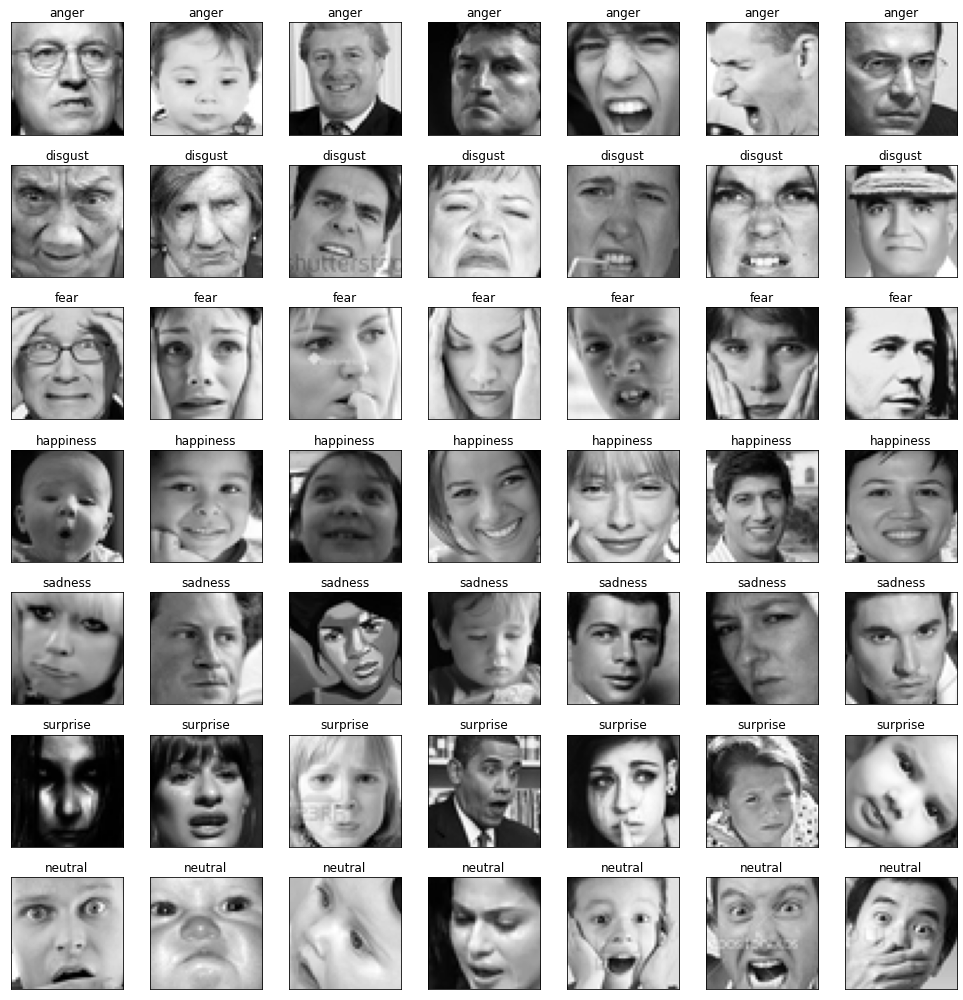

In [55]:
fig = pyplot.figure(1, (14, 14))

random.seed(0)
n = random.randint(0, high=20)
# n = 194
k = 0
print(n)

for label in sorted(test_data.predicted_label.unique()):
    for j in range(7):
        px = test_data[test_data.predicted_label==label].pixels.iloc[n]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        n += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        pyplot.tight_layout()

#### Test on a new dataset

In [56]:
test_data2 = pd.read_json("colab_direcoty/color.json")
test_data2

,img_name,img_array,label
0,Angry.9677.jpg,"[[33, 35, 35, 30, 27, 30, 39, 46, 33, 42, 61, ...",angry
1,Angry.26462.jpg,"[[103, 103, 95, 73, 50, 37, 36, 38, 41, 61, 72...",angry
2,19187Exp0frightened_programmer_292.jpg,"[[180, 178, 176, 176, 177, 177, 178, 178, 178,...",angry
3,5035Exp0awe_teacher_414.jpg,"[[77, 71, 69, 74, 77, 72, 63, 56, 53, 55, 60, ...",angry
4,18407Exp0frightened_by_the_movie_woman_2.jpg,"[[29, 31, 72, 50, 46, 37, 66, 100, 107, 199, 1...",angry
...,...,...,...
92963,Surprise.20439.jpg,"[[250, 204, 118, 54, 45, 48, 45, 49, 49, 57, 5...",surprise
92964,Surprise.21727.jpg,"[[81, 49, 0, 28, 161, 186, 190, 198, 210, 208,...",surprise
92965,46523Exp5amazed_boy_143.jpg,"[[250, 254, 247, 220, 143, 103, 92, 90, 83, 90...",surprise
92966,75069Exp5afraid_father_738.jpg,"[[179, 145, 69, 28, 30, 28, 30, 31, 28, 26, 21...",surprise


In [57]:
# Align the label name with training sample 

# emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}
anger_index = test_data2[test_data2["label"] == "angry"].index
happy_index = test_data2[test_data2["label"] == "happy"].index
sad_index = test_data2[test_data2["label"] == "sad"].index
test_data2.loc[anger_index, "label"] = "anger"
test_data2.loc[happy_index, "label"] = "happiness"
test_data2.loc[sad_index, "label"] = "sadness"

In [58]:
test_data2["label"].value_counts()

neutral      29384
happiness    28592
sadness      12223
surprise      8113
anger         6566
fear          4859
disgust       3231
Name: label, dtype: int64

In [59]:
X_test2 = np.array(test_data2['img_array'].values.tolist()).reshape(len(test_data2), 48, 48, 1)
y_test2 = le.transform(test_data2["label"])
cnn_model.evaluate(X_test2, y_test2)

2906/2906 [==============================] - 13s 4ms/step - loss: 255.4758 - accuracy: 0.5648


[255.4757537841797, 0.5647857189178467]

In [1]:
test_data2["predicted_emotion"] = le.inverse_transform(np.argmax(cnn_model.predict(X_test2), axis=-1))
test_data2["predicted_label"] = np.argmax(cnn_model.predict(X_test2), axis=-1)
test_data2

NameError: ignored

In [ ]:
fig = pyplot.figure(1, (14, 14))

random.seed(0)
n = random.randint(0, high=20)
# n = 194
k = 0
print(n)

for label in sorted(test_data2.predicted_label.unique()):
    for j in range(7):
        px = test_data2[test_data2.predicted_label==label].pixels.iloc[n]
        # px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        n += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        pyplot.tight_layout()